# Ch 5. 非監督式學習：降維與分群
## 5-2. k-means 分群
[5-2-1. 建立 k-means 分群](#sec5_2_1)  
[5-2-2. 評估分群結果](#sec5_2_2)
***

<a id='sec5_2_1'></a>
## 5-2-1. 建立 k-means 分群

In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Pokemon_894_12.csv')

# 對寶可夢兩個屬性的 SpecialAtk, SpecialDef 進行分群
t1, t2 = 'Bug', 'Psychic'
df_clf = df[(df['Type1']==t1) | (df['Type1']==t2)]
df_clf = df_clf[['Type1','SpecialAtk', 'SpecialDef']]

# 過濾出兩個屬性
df_clf.reset_index(inplace=True)
idx_0 = [df_clf['Type1']==t1]
idx_1 = [df_clf['Type1']==t2]

# 標準化
X = df_clf[['SpecialAtk', 'SpecialDef']]
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)
print(X_std[:2, :])

[[-1.39076263 -1.66670756]
 [-1.26781386 -1.51507461]]


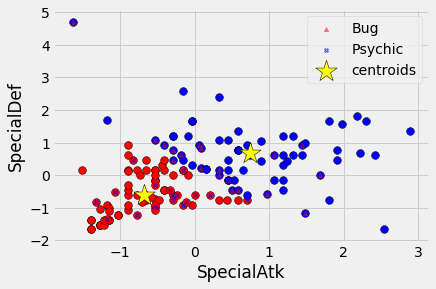

In [2]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, init='random')
y_pred = km.fit_predict(X_std)

def plt_scatter(X_std, y_pred, km):
    # 設定顏色
    c1, c2 = 'red', 'blue'
        
    plt.scatter(X_std[y_pred==0, 0], 
                X_std[y_pred==0, 1], 
                color=c1, edgecolor='k', s=60)
    plt.scatter(X_std[y_pred==1, 0], 
                X_std[y_pred==1, 1], 
                color=c2, edgecolor='k', s=60)
    
    if len(X_std[y_pred==0]) < len(X_std[y_pred==1]):
        c1, c2 = 'blue', 'red'
        
    plt.scatter(X_std[idx_0[0], 0], 
                X_std[idx_0[0], 1], 
                color=c1, marker='^', alpha=.5, 
                s=20, label=t1)
    plt.scatter(X_std[idx_1[0], 0], 
                X_std[idx_1[0], 1], 
                color=c2, marker='X', alpha=.5, 
                s=20, label=t2)
    plt.scatter(km.cluster_centers_[:, 0], 
                km.cluster_centers_[:, 1], 
                s=500, marker='*', c='yellow', 
                edgecolor='black', label='centroids')
    plt.xlabel('SpecialAtk')
    plt.ylabel('SpecialDef')
    plt.legend()

plt_scatter(X_std, y_pred, km)

<a id='sec5_2_2'></a>
## 5-2-2. 評估分群結果

上圖針對寶可夢的兩個屬性進行 k-means 分群，並將結果繪製成散點圖。
因為已經知道是兩個屬性的分群，所以設定 k=2 (n_clusters=2)。
圖中藍色與紅色圈圈顯示兩個分群的結果，且進一步以藍色三角形標示 Bug 屬性，以紅色叉叉標示 Psychic 屬性。
換言之，只要圈圈的顏色有異常，即代表分群錯誤。

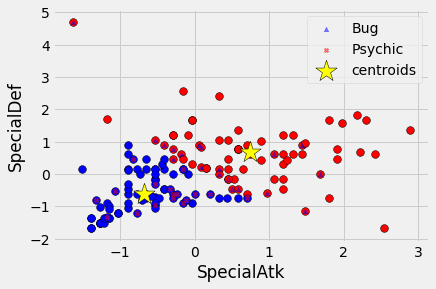

In [3]:
km = KMeans(n_clusters=2, init='k-means++')
y_pred = km.fit_predict(X_std)
plt_scatter(X_std, y_pred, km)

In [4]:
# 對寶可夢兩個屬性的 SpecialAtk, SpecialDef 進行分群
lst_type = ['Fairy', 'Fighting', 'Steel', 'Ice']
df_clf = df[df['Type1']==lst_type[0]]

for i in range(1, len(lst_type)):
    df_clf = df_clf.append(df[df['Type1']==lst_type[i]])

X = df_clf[['SpecialAtk', 'SpecialDef']]
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)
X.shape

(102, 2)

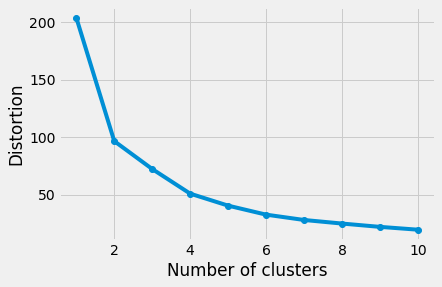

In [5]:
lst_dst = []

# 嘗試 10 個 k 值並記錄分群結果的 SSE
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(X_std)
    lst_dst.append(km.inertia_)

plt.plot(range(1, 11), lst_dst, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion');

n_clusters = 2 ，所有樣本的輪廓係數平均 = 0.48203536275839154
n_clusters = 4 ，所有樣本的輪廓係數平均 = 0.3917905617415923


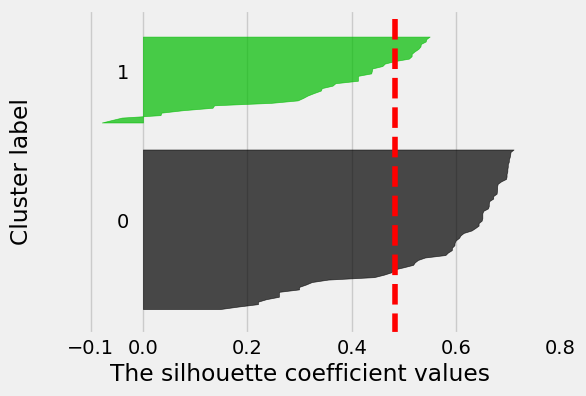

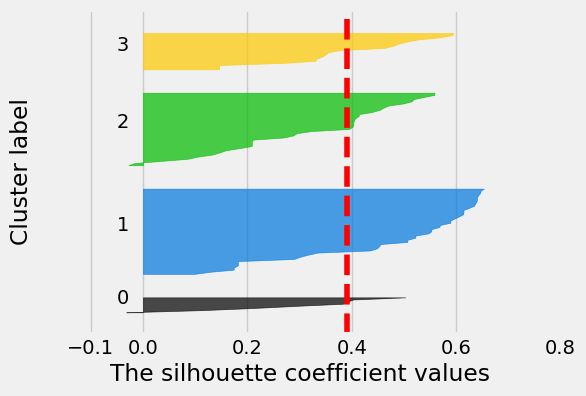

In [6]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score

for n_clusters in [2, 4]:
    fig, ax = plt.subplots(1, 1, dpi=100)
    # 雖然輪廓係數範圍是[-1, 1]，但這裡只顯示[-0.2, 0.8]之間
    ax.set_xlim([-.2, .8])
    ax.set_ylim([0, len(X_std)+(n_clusters+1)*10])
    # 建立 k-means 模型並擬合數據
    km = KMeans(n_clusters=n_clusters, random_state=0)
    y_pred = km.fit_predict(X_std)
    # 取出分群結果的標籤
    labels = np.unique(y_pred)
    # 計算所有樣本的輪廓係數平均值
    silhouette_avg = silhouette_score(X_std, y_pred)
    print("n_clusters =", n_clusters,
          "，所有樣本的輪廓係數平均 =", silhouette_avg)
    # 計算每個樣本的輪廓係數
    silhouette = silhouette_samples(X_std, y_pred, 
                                    metric='euclidean')
    y_lower = 10
    for i, c in enumerate(labels):
        c_silhouette = silhouette[y_pred == c]
        c_silhouette.sort()
        size_cluster_i = c_silhouette.shape[0]
        y_upper = y_lower + size_cluster_i
        # 產生顏色編號，並填入區間內
        color = cm.nipy_spectral(float(i)/n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, 
                         c_silhouette, facecolor=color, 
                         edgecolor=color, alpha=0.7)
        # 標示集群標籤
        ax.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8])